# Chapter 3: IID modeling

In [1]:
# Core numerical computing
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, multivariate_t
from scipy import linalg

# Financial data handling
import yfinance as yf

# Book data (pip install "git+https://github.com/dppalomar/pob.git#subdirectory=python")
from pob_python import SP500_stocks_2015to2020, SP500_index_2015to2020

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from tqdm import tqdm  # For progress tracking

We use the S&P500 index dataset from January 2015 to September 2020

In [9]:
# Use S&P 500 index from the book data
SP500_index_2015to2020.tail(3)

,SP500_INDEX
Date,
2020-09-18,3319.47
2020-09-21,3281.06
2020-09-22,3315.57


We remove the dates from the data keeping the values in the same order

In [16]:
sp500_prices = SP500_index_2015to2020.values.squeeze()
sp500_prices

array([2020.58, 2002.61, 2025.9 , ..., 3319.47, 3281.06, 3315.57])

We compute the log returns and drop the first difference

In [17]:
sp500_returns = np.diff(np.log(sp500_prices))[1:]

We calculate the sample returns mean and variance

In [19]:
mu = np.mean(sp500_returns)
var = np.var(sp500_returns)
print('Sample log return mean: {:.2f}, and variance: {:.5f}'.format(mu, var))

Sample log return mean: 0.00, and variance: 0.00014


We generate synthetic data by sampling from a normal distribution using the mean and variance of the S&P500 log returns

In [20]:
np.random.seed(42)
T = 500
x = np.random.normal(mu, np.sqrt(var), T)

we create a DataFrame with a time index and the synthetic data

In [24]:
df = pd.DataFrame({'t': np.arange(1, T + 1), 'x': x})

We plot the synthetic data

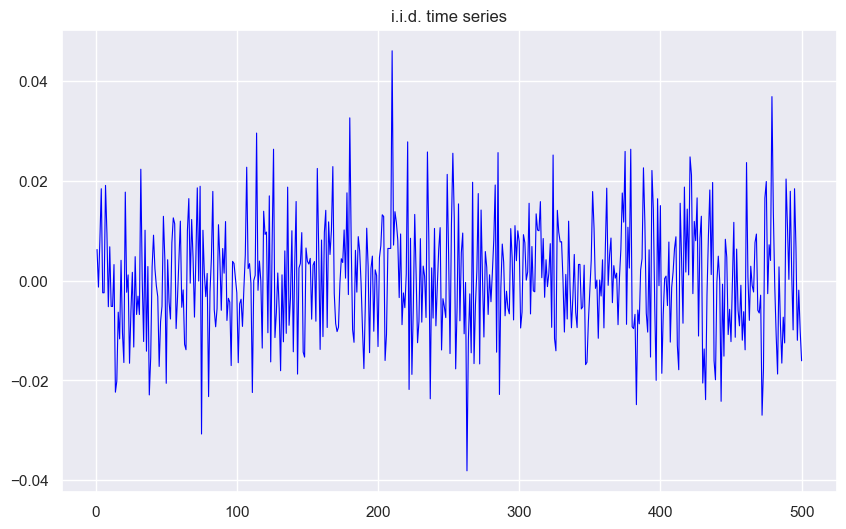

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df['t'], df['x'], linewidth=0.8, color='blue')
plt.title('i.i.d. time series')
plt.xlabel('')
plt.ylabel('')
plt.show()

## Sample estimators
We calculate the classic estmators of the time series, i.e. the sample mean and the sample covariance matrix

$$\mu = \frac{1}{T} \sum_{t=1}^T x_t$$

$$\hat{\Sigma} = \frac{1}{T-1} \sum_{t=1}^T (x_t - \mu)(x_t - \mu)^{tr}$$

We generate Gaussian synthetic return data in two time series and 10 periods

In [28]:
np.random.seed(42)
N = 2
T = 10
mu_true = np.zeros(N)
Sigma_true = np.array([[0.0012, 0.0011],
                       [0.0011, 0.0014]])
X = np.random.multivariate_normal(mean=mu_true, cov=Sigma_true, size=200)
#X = multivariate_normal.rvs(mean=mu_true, cov=Sigma_true, size=200)
X_ = X[:T, :]
X_.shape

(10, 2)

We calculate the estimators

In [27]:
mu_sm = np.mean(X_, axis=0)  # classical mean estimator (sample mean)
mu_sm

array([0.0077381 , 0.00520034])

We center the distributions and then we calculate the covariance matrix of the two time series

In [29]:
X_centered = X_ - mu_sm
Sigma_scm = np.cov(X_centered.T) # classical covariance estimator (sample covariance matrix)
print(np.linalg.norm(mu_sm - mu_true))
print(np.linalg.norm(Sigma_scm - Sigma_true, 'fro') / np.linalg.norm(Sigma_true, 'fro'))

0.009323178928090176
0.17331755138107485


In [30]:
from matplotlib.patches import Ellipse

def confidence_ellipse(cov, mean, ax, n_std=2, **kwargs):
    """Create covariance ellipse with proper scaling"""
    vals, vecs = np.linalg.eigh(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    return Ellipse(xy=mean, width=width, height=height, angle=theta, fill=False, **kwargs)

We draw the scatter plot of the two synthetic time series with corrected ellipses

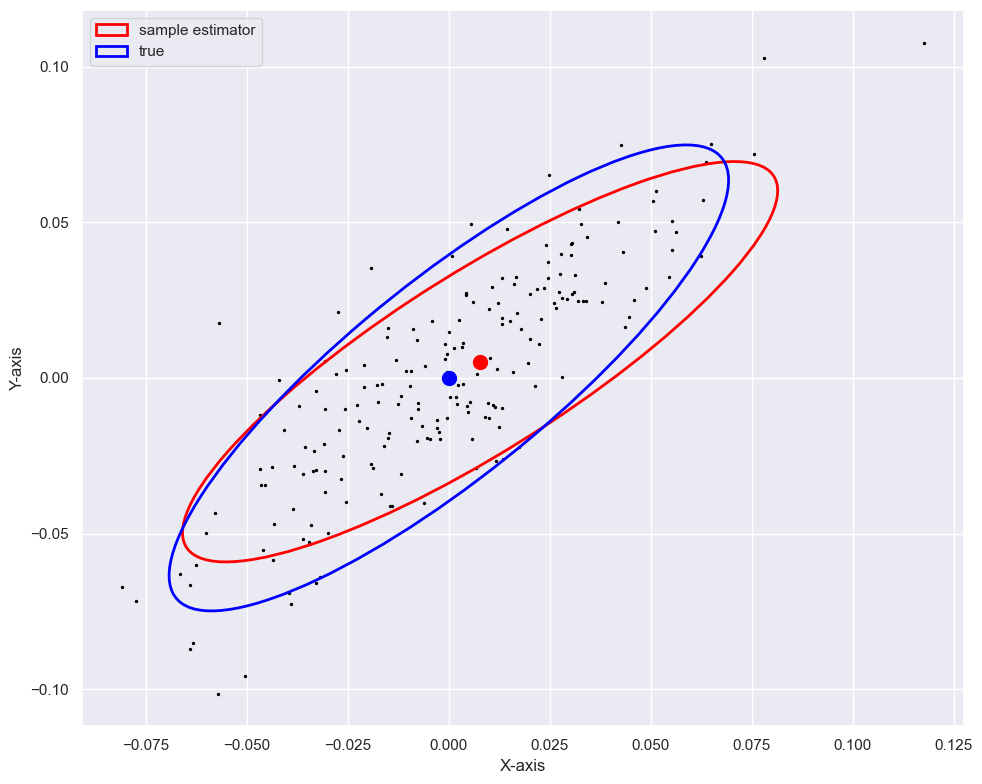

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot data points
ax.scatter(X[:, 0], X[:, 1], color='black', s=2)

# Add ellipses with 95% confidence (n_std=2)
ax.add_patch(confidence_ellipse(Sigma_scm, mu_sm, ax, n_std=2, 
                                edgecolor='red', linewidth=2, label='sample estimator'))
ax.add_patch(confidence_ellipse(Sigma_true, mu_true, ax, n_std=2,
                                edgecolor='blue', linewidth=2, label='true'))

# Plot mean estimates with big colored dots
ax.scatter(mu_sm[0], mu_sm[1], color='red', s=100)
ax.scatter(mu_true[0], mu_true[1], color='blue', s=100)

# Configure plot
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()
plt.tight_layout()
plt.show()